## Project: Property price prediction<br>
### Project objective <br>
Need to built the model to predict property price by its features.

In [13]:
# import all packages
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import dtale
from ydata_profiling import ProfileReport
import json
import ast
import pdb
import re
import plotly.express as px
import math
import pdb
from uszipcode import SearchEngine
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter
import os
random_seed = 42
from sklearn.feature_selection import f_classif, mutual_info_classif, f_regression, RFE, SelectFromModel, RFECV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest, StackingRegressor, BaggingRegressor

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders import CountEncoder, HashingEncoder, BinaryEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from scipy.stats import spearmanr
import time
import gc


pd.options.display.float_format = "{:.3f}".format

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [14]:
# function 

def print_evaluation_metrics(y_test, y_pred):
    """
    Calculates and prints evaluation metrics for model predictions.

    Parameters:
        y_test (array-like): True values of the target variable.
        y_pred (array-like): Predicted values of the target variable.
    """
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    nrmse = rmse/(y_test.max() - y_test.min())
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    meae = median_absolute_error(y_test, y_pred)
    
    print(f'{round(mse, 3)} MSE')
    print(f'{round(rmse, 3)} RMSE')
    print(f'{round(nrmse, 3)} normalized RMSE')
    print(f'{round(r2, 3)} R2 score')
    print(f'{round(mae, 3)} MAE')
    print(f'{round(mape, 3)} MAPE')
    print(f'{round(meae, 3)} MeAE')

In [15]:
# read the cleaned data
data = pd.read_csv('./feature_data_new.csv')

/tmp/ipykernel_5529/2053635140.py:2: DtypeWarning:

Columns (5,72) have mixed types. Specify dtype option on import or set low_memory=False.



# EDA

In [16]:
# remove not needed columns
data.drop(['zipcode', 'mls_id', 'street', 'stories', 'lotsize', 'lotsize_metric', 'school_distance', 'fireplace_heating'\
                , 'heating', 'cooling_fact', 'price_sqft', 'sqft', 'bed_bath_ind', 'school_grades', 'school_name'\
                ], axis=1, inplace=True)

# there are some propertyType which are houses but have also 'land' value, need to remove 'land' value there
cond = data.propertyType.str.contains('land') & ((data.story!=0) | (data.baths!=0) | (data.beds!=0))
data.loc[cond, 'propertyType'] = data.loc[cond, 'propertyType'].str.replace('land, ', '')
data.loc[cond, 'prop_land'] = 0

# replace by for_rent status too cheap houses not in detroit city
cond = (data.target < 10000) & (data.status != 'for rent') & (data.propertyType != 'land, other')\
        & (data.propertyType != 'land') & (data.major_city != 'detroit')
data.loc[cond, ['status']] = 'for rent'
data.loc[data.status == 'for rent', 'rent'] = 1

# create detroit city column as there are very cheap property there
data['city_detroit'] = data.major_city.apply(lambda x: 1 if x == 'detroit' else 0)

### Feature selection

In [17]:
# prepare the list of non informative features 
low_information_cols = []

for col in data.columns:
    # calculate most frequent value in the feature
    top_freq = data[col].value_counts(normalize=True).max()
    # calculate proportion of unique values from feature size
    non_nan_values = data[col].count()
    nunique_ratio = data[col].nunique() / non_nan_values
    
    # compare frequency with the threshold
    if top_freq > 0.99:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% the same values')
    # compare proportion of unique values with threshold
    if nunique_ratio > 0.99:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% unique values')

rent: 99.49% the same values
cool_refrigeration: 99.01% the same values
heat_central gas: 99.03% the same values
timezone_phoenix: 99.01% the same values
city_detroit: 99.05% the same values


All the columns in low_information_col list are binary features and only 5 of them (rent, cool_refrigeration, heat_central gas,<br>
timezone_phoenix, city_detroit) have more than 99% of the same values, need to investigate them later using correlations.

In [18]:
# Get the list of all columns
all_columns = data.columns.tolist()

# Select numerical columns
# Define the list of prefixes to exclude
prefixes = ['timezone', 'cool', 'heat', 'state', 'city', 'county', 'gpt_status', 'status', 'propertyType', 'unknown'\
            , 'low rise', 'detached', 'condo', 'townhome', 'multi family', 'coop', 'traditional', 'high rise'\
            , 'row', 'not_top_property', 'major_city', 'not_top', 'area_code_list', 'bounds', 'target', 'school_rating_min_fr'\
            , 'school_rating_max_fr', 'school_rating_mean_fr', 'school_rating_med_fr', 'prop_', 'parking', 'lotsize_na_out'\
            , 'lotsize_na', 'beds_na', 'story_na', 'baths_na', 'bed_bath_ind', 'year_built_na', 'remodeled_na', 'rent', 'private_pool']

# Filter out the columns based on prefixes and data type
numerical_columns = [col for col in all_columns if not col.startswith(tuple(prefixes))]
numerical_columns.extend(['parking_number'])
# numerical_columns

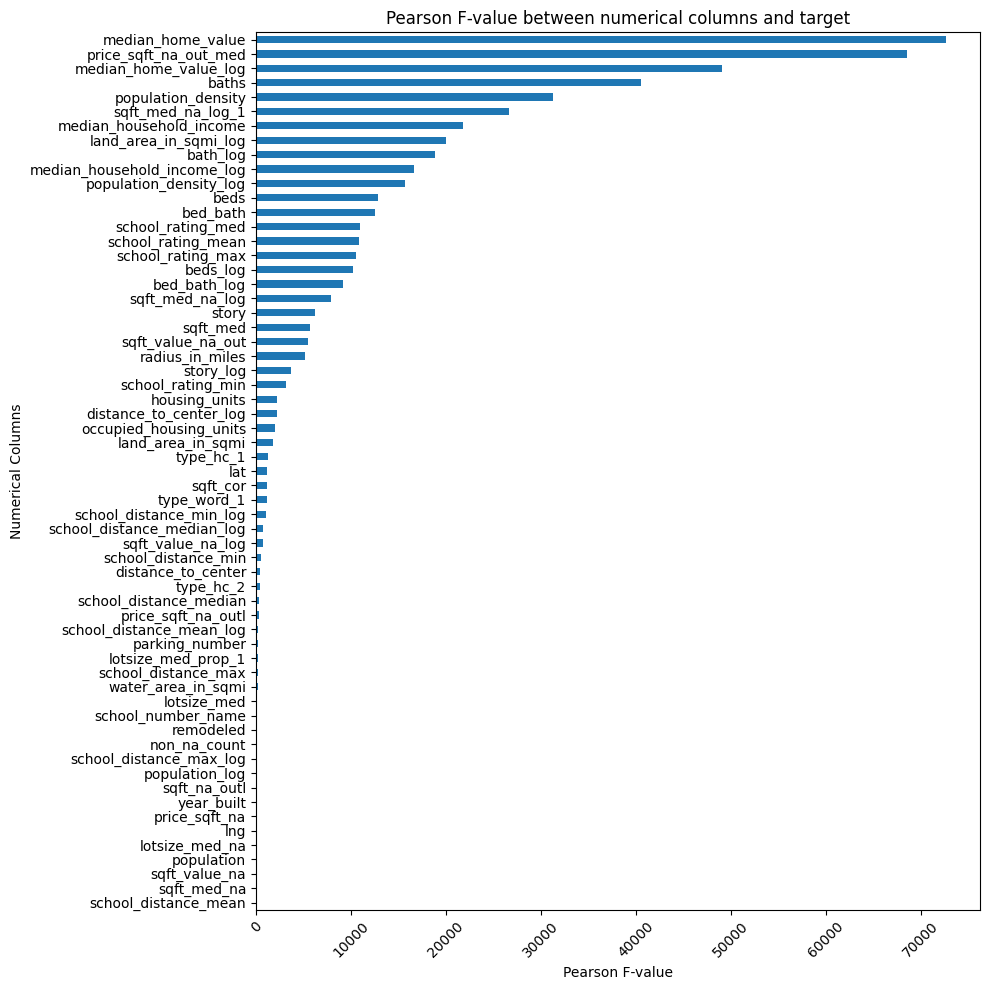

In [19]:
# calculate Pearson's F-value for numerical columns and plot the result
pearson = pd.Series(f_regression(data[numerical_columns], data['target'])[0], index = numerical_columns)
pearson.sort_values(inplace = True)
plt.figure(figsize=(10, 10))
pearson.plot(kind='barh')
plt.ylabel('Numerical Columns')
plt.xlabel('Pearson F-value')
plt.title("Pearson F-value between numerical columns and target")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

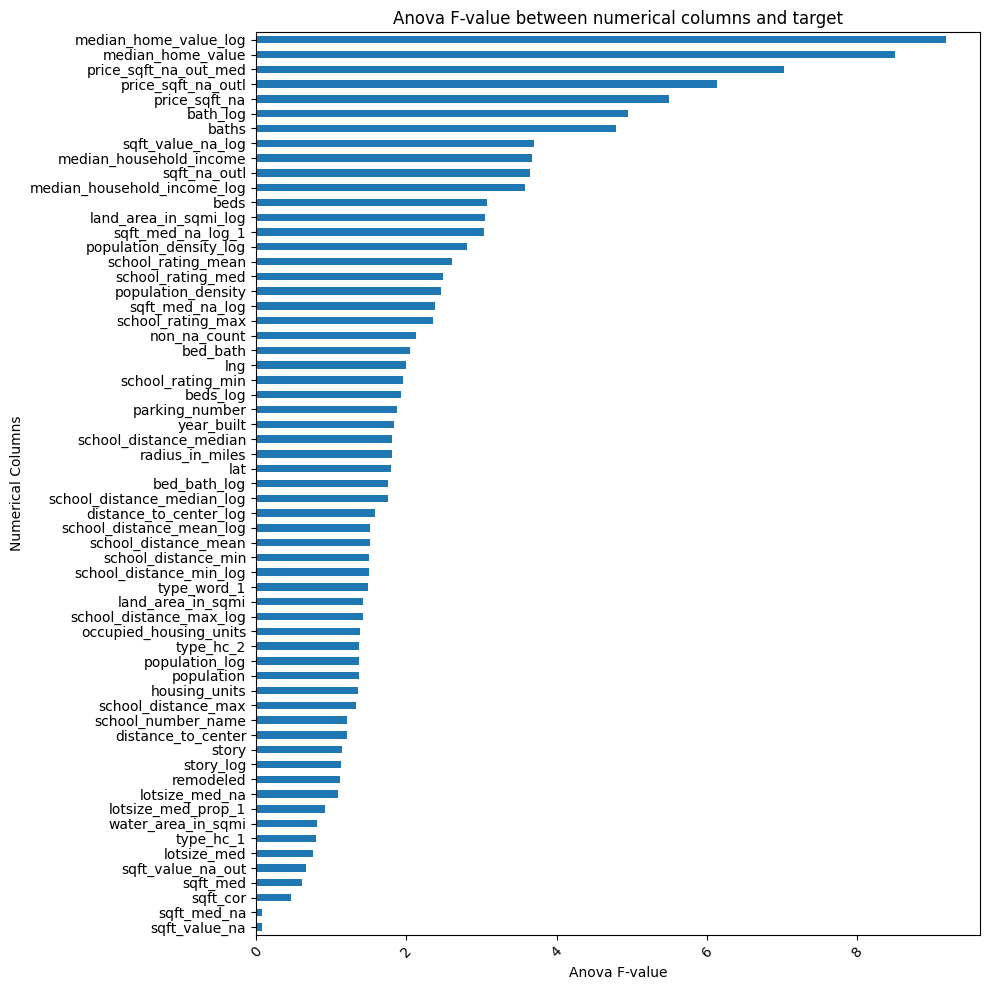

In [20]:
# Compute the ANOVA F-value for numerical_columns
anova = pd.Series(f_classif(data[numerical_columns], data['target'])[0], index = numerical_columns)
anova.sort_values(inplace = True)
plt.figure(figsize=(10, 10))
anova.plot(kind='barh')
plt.ylabel('Numerical Columns')
plt.xlabel('Anova F-value')
plt.title('Anova F-value between numerical columns and target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

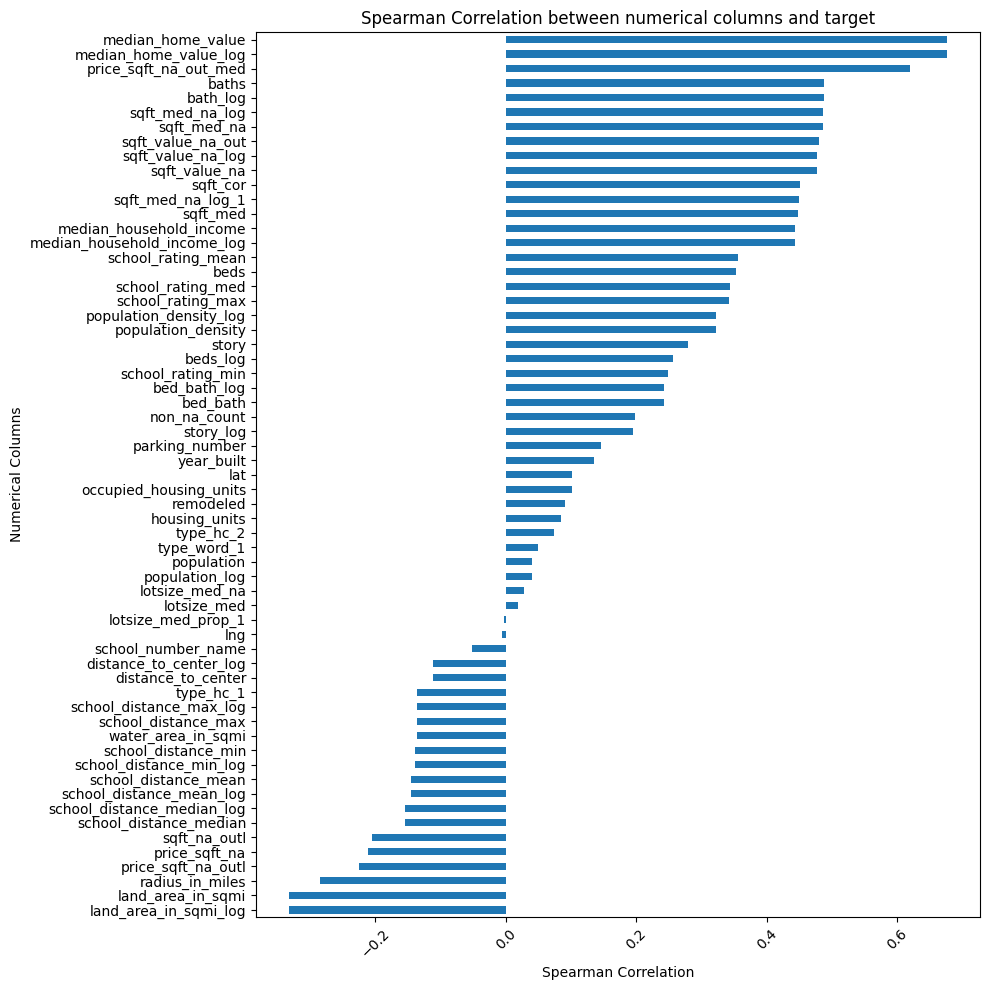

In [21]:
# calculate Spearman correlation
correlations = {}
for column in numerical_columns:
    correlation, _ = spearmanr(data[column], data['target'])
    correlations[column] = correlation

# Convert correlations dictionary to a pandas Series for easier plotting
correlation_series = pd.Series(correlations)
correlation_series.sort_values(inplace=True)

# Plotting the correlations in a bar plot
plt.figure(figsize=(10, 10))
correlation_series.plot(kind='barh')
plt.ylabel('Numerical Columns')
plt.xlabel('Spearman Correlation')
plt.title('Spearman Correlation between numerical columns and target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

According to Pearson and Spearman correlation top numerical features that significantly affect the target:
- median_home_value;
- price_sqft_na_out_med;
- baths;
- population_density;
- median_household_income; <br>
<br>
Most of the features connected with money

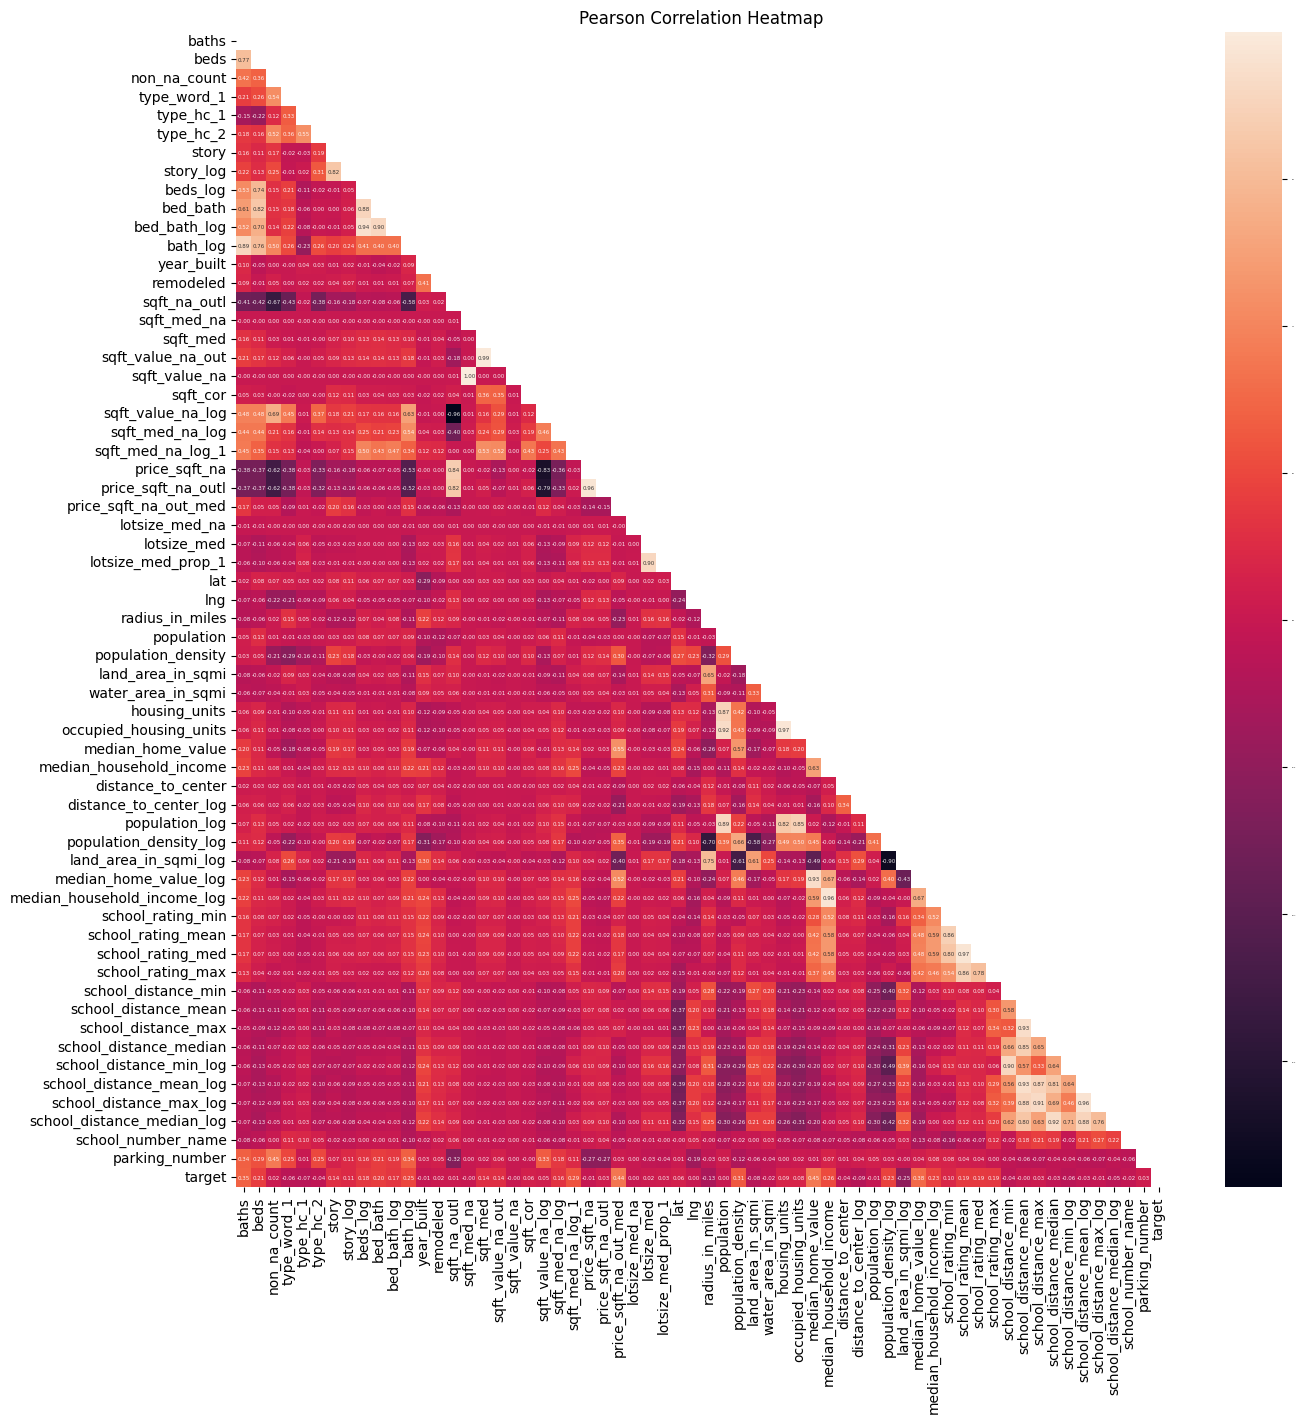

In [22]:
# pearson correlation
matrix = np.triu(data[numerical_columns + ['target']].corr())
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(data[numerical_columns + ['target']].corr(), xticklabels=True, yticklabels=True\
            , annot=True, mask=matrix, fmt = '.2f', annot_kws={"size": 4, "alpha" : 0.9})
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=1)
plt.title('Pearson Correlation Heatmap')
plt.savefig('test_pearson.png', dpi=600)

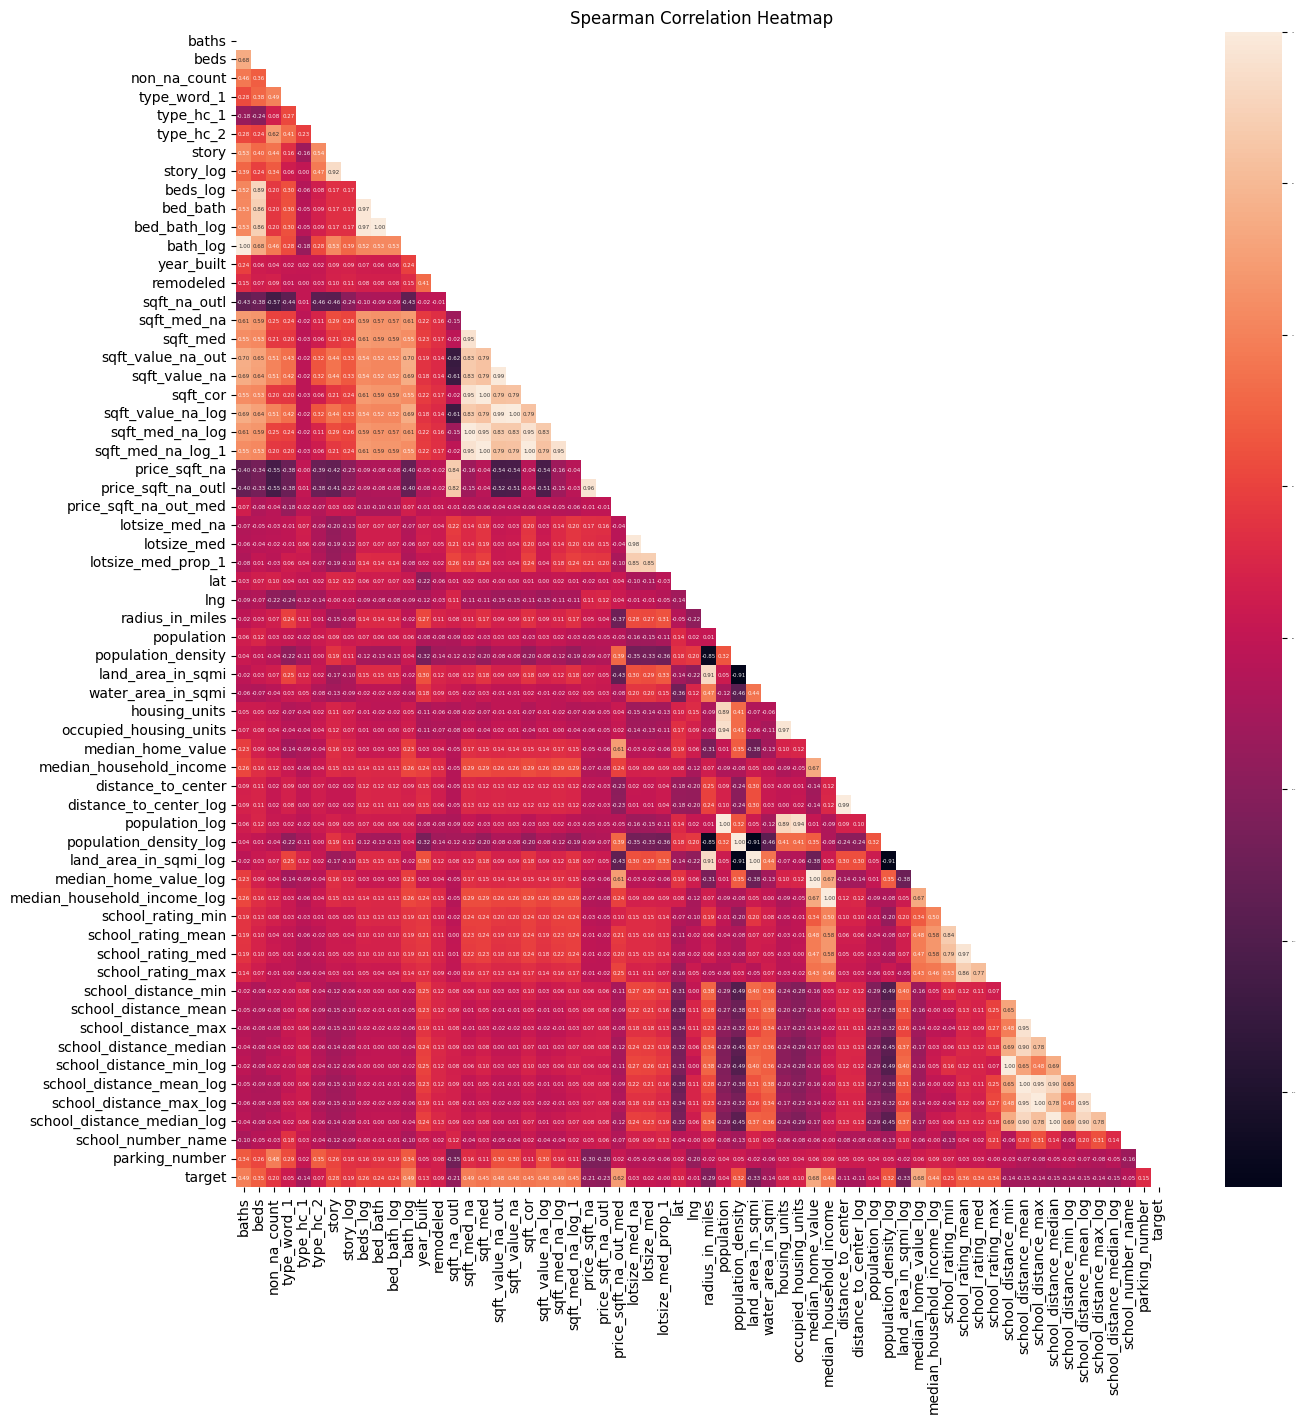

In [23]:
# spearman correlation
matrix = np.triu(data[numerical_columns + ['target']].corr(method = 'spearman'))
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(data[numerical_columns + ['target']].corr(method = 'spearman'), xticklabels=True, yticklabels=True\
            , annot=True, mask=matrix, fmt = '.2f', annot_kws={"size": 4, "alpha" : 0.9})
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=1)
plt.title('Spearman Correlation Heatmap')
plt.savefig('test_spearman.png', dpi=600)

Correlations higher than 0.8 were investigated and only 1 feature in each pair was selected.
- school_rating_min/max/med/mean have high correlation coeff with each other, need to select only one feature <br>
(could be selected min and max column as they have not so high correlation with each other) or bind them all together;
- school_distance_max/mean/median + all log columns have high correlation with each other, need to select only one <br>
column (median) from those 3 or bind them together using pca. Min column stay untouched, log value will be used; 
- baths column has better corr coeff with target than other baths columns, will use it;
- beds column has better corr coeff with target than other bed columns, will use it;
- population_density has higher corr coeff than log column;
- story has higher  corr coeff than log column;
- lotsize_med_prop_1 and lotsize_med_na have higher correlation coeff in pearson corr, but all lotsize columns have very low almost zero <br> 
correlation with target, lotsize_med_prop_1 will be used or all lotsize columns could be bind together using pca;
- type_word_1, type_hc_1, type_hc_2 don't have high correlation with other columns, use all these columns;
- sqft_med_na_log_1 has the highest corr coeff with target;
- population, housing_untis, occupied_housing_units have high correlation with each other, need to select 1 column (occupied_housing_units) or bind all together using pca;
- year_built and remodeled have no other highly correlated columns, use both columns, but they have low correlation with target;
- price_sqft_na_out_med has the highest correlation with target among price_sqft columns, could try log value
- lat could be used it doesn't have high corr with another columns but have corr with target column;
- lng column according to pearson and spearman correlation have low, almost zero correlation with target and don't have high corr with another columns,<br> could be used or could be removed;
- according to pearson correlation radius_in_miles has high corr only with population_density_log, according to spearman correlation<br>
it has also high corr coeff with population_density column, will try to use both population_density and radius_in_miles or could try to bind them;
- water_area_in_sqmi have low corr in pearson but higher in spearman;
- median_home_value has better correlation with target;
- median_household_income has better corr with target;
- distance_to_center_log has better corr with target in pearson and anova test and almost the same with unlog in spearman;
- parking_number has very low correlation in pearson and anova test but higher in spearman corr;
- land_area_in_sqmi_log has better corr with target;

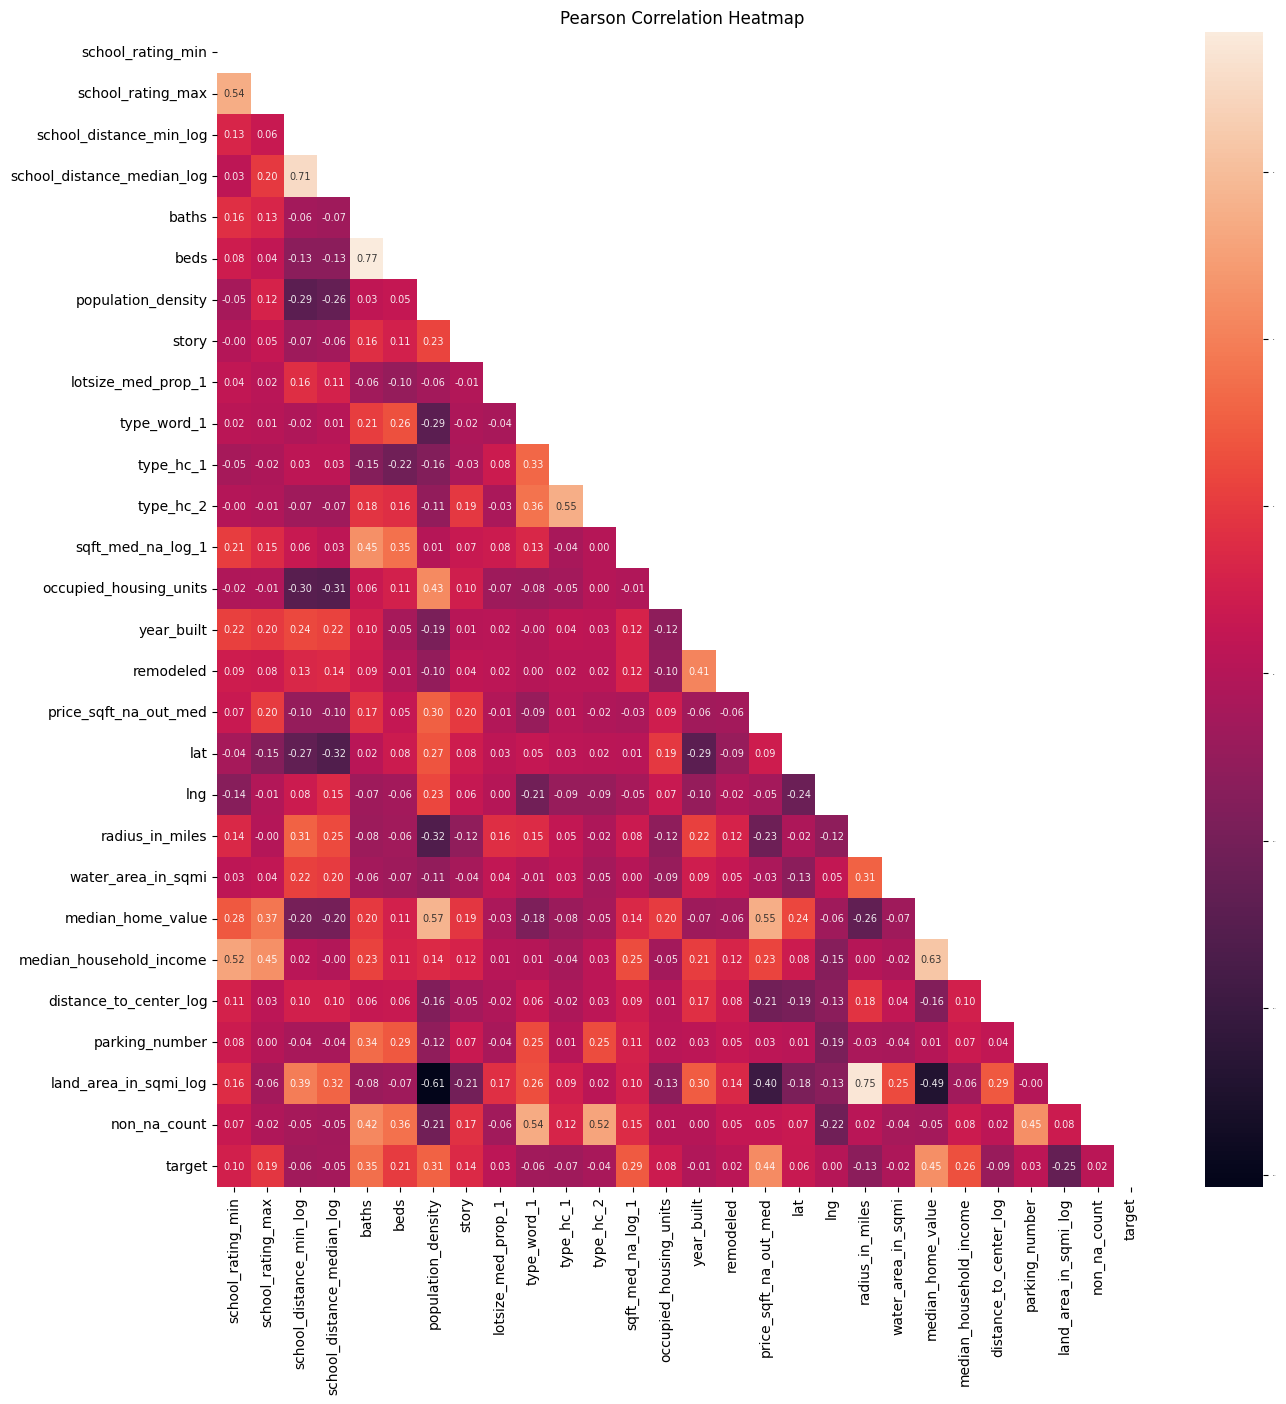

In [24]:
# Check selected numerical columns correlation
selected_num_col = ['school_rating_min', 'school_rating_max', 'school_distance_min_log', 'school_distance_median_log', 'baths'\
                , 'beds', 'population_density', 'story', 'lotsize_med_prop_1', 'type_word_1', 'type_hc_1', 'type_hc_2'\
                , 'sqft_med_na_log_1', 'occupied_housing_units', 'year_built', 'remodeled', 'price_sqft_na_out_med', 'lat', 'lng'\
                , 'radius_in_miles', 'water_area_in_sqmi', 'median_home_value', 'median_household_income', 'distance_to_center_log'\
                , 'parking_number', 'land_area_in_sqmi_log', 'non_na_count']

# pearson correlation
matrix = np.triu(data[selected_num_col + ['target']].corr())
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(data[selected_num_col + ['target']].corr(), xticklabels=True, yticklabels=True\
            , annot=True, mask=matrix, fmt = '.2f', annot_kws={"size": 7, "alpha" : 0.9})
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=1)
plt.title('Pearson Correlation Heatmap')
plt.savefig('test_pearson_selected.png', dpi=600)

#### Cateforical feature selection

In [25]:
# Select categorical and binary columns
excepting_col = ['bounds_north', 'bounds_south', 'bounds_west', 'bounds_east', 'target', 'target_log']
categorical_features = list(set(all_columns) - set(numerical_columns) - set(excepting_col))

# prepare new df for category feature selection
cat_df = data.loc[:, categorical_features + ['target']]

# Select object type columns
object_columns = cat_df.select_dtypes(include='object').columns.tolist()

# encode categorical data using label encoder
label_encoder = LabelEncoder()

for column in object_columns:
    cat_df[column] = label_encoder.fit_transform(cat_df[column])

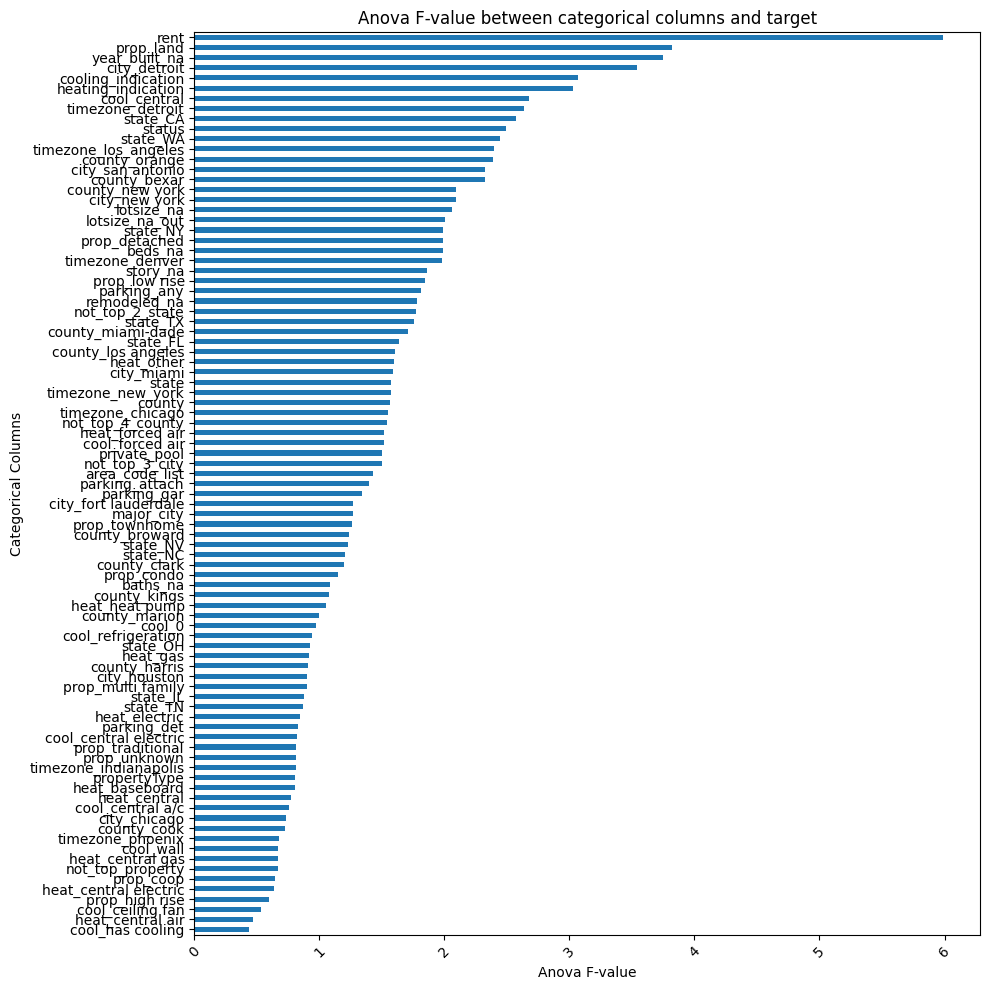

In [26]:
# perform anova test to categorical features
anova = pd.Series(f_classif(cat_df[categorical_features], data['target'])[0], index = categorical_features)
anova.sort_values(inplace = True)
plt.figure(figsize=(10, 10))
anova.plot(kind='barh')
plt.ylabel('Categorical Columns')
plt.xlabel('Anova F-value')
plt.title('Anova F-value between categorical columns and target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/home/alena/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning:

overflow encountered in scalar multiply

/home/alena/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning:

overflow encountered in scalar multiply



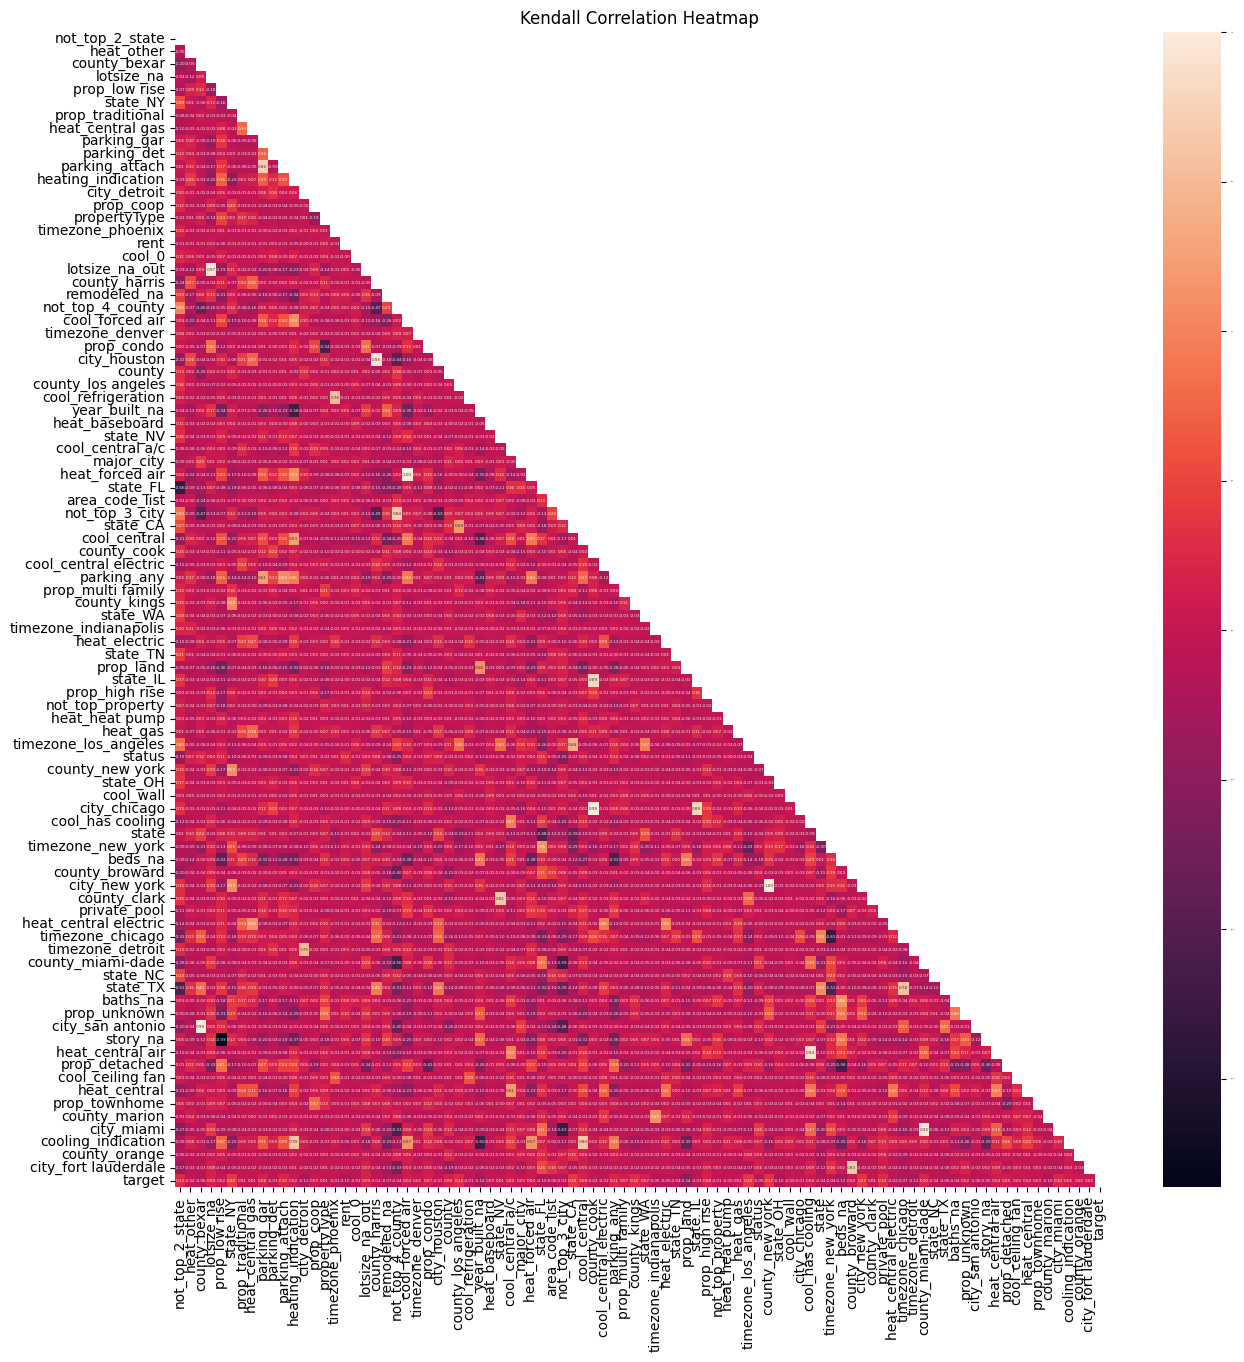

In [27]:
# kendall correlation
matrix = np.triu(cat_df[categorical_features + ['target']].corr(method = 'kendall'))
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(cat_df[categorical_features + ['target']].corr(method = 'kendall'), xticklabels=True, yticklabels=True\
            , annot=True, mask=matrix, fmt = '.2f', annot_kws={"size": 3, "alpha" : 0.9})
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=1)
plt.title('Kendall Correlation Heatmap')
plt.savefig('test_kendall.png', dpi=600)


Pairs with correlation coefficient equal or higher than 0.8 were investigated and only 1 first feature was selected.<br>
In cases when it was not so obvious, RandomForestRegressor feature_importance were used.<br>
- county_harris has higher f-value in anova test and the same kendall corr with target in comparison with city_houston;
- lotsize_na has higher f-value and same kendall corr with target in comparison with lotsize_na_out;
- cooling_indication has higher f-value and kendall corr with target in comparison with heating_indication <br>
(according to RandomForestRegressor feature importance heating_indication has higher coeff); 
- county_miami-dade has higher f-value and the same kendall corr coef with target in comparison with city_miami;
- timezone_chicago had lower f-value but higher kendall corr with target in comparison with state_TX;
- not_top_3_city has lower kendall corr coef and f-value but it has higher feature importance in RFR in comparison with not_top_4_county;
- heat_forced air has higher f-value, the same kendall corr coef and higher feature importance in RFR in comparison with cool_forced air;
- state_NV has higher f-value and the same kendall corr coef with target in comparison with county_clark;
- city_san antonio has higher f-value and the same kendall corr coef with target in comparison with county_bexar;
- cool_has cooling  has the same kendall corr coeff and lower f-value but has higher RFR feature importance in comparison with heat_central air;
- parking_attach has higher f-value and kendall corr coef with target in comparison with parking_gar;
- story_na has higher f-value and kendall corr coef with target in comparison with prop_low_rise;
- county_broward has lower f-value and the same kendall corr coef with target in comparison with city_fort lauderdale<br> 
- state_IL has higher kendall corr coef with target and f-value in comparison with county_cook and city_chicago;
- city_new_york has higher f-value and equal kendall corr with target in comparison with county_new_york;

In [28]:
# prepare list of selected categorical columns
exclude_col = {'city_houston', 'county_dallas', 'lotsize_na_out', 'heating_indication', 'prop_row', 'city_miami', 'state_TX'\
                , 'not_top_4_county', 'cool_forced air', 'county_clark', 'county_bexar', 'heat_central air', 'parking_gar'\
                , 'prop_low rise', 'city_fort lauderdale', 'county_cook', 'city_chicago', 'county_new york'}
selected_cat_col = list(set(categorical_features) - exclude_col)

/home/alena/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning:

overflow encountered in scalar multiply

/home/alena/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning:

overflow encountered in scalar multiply



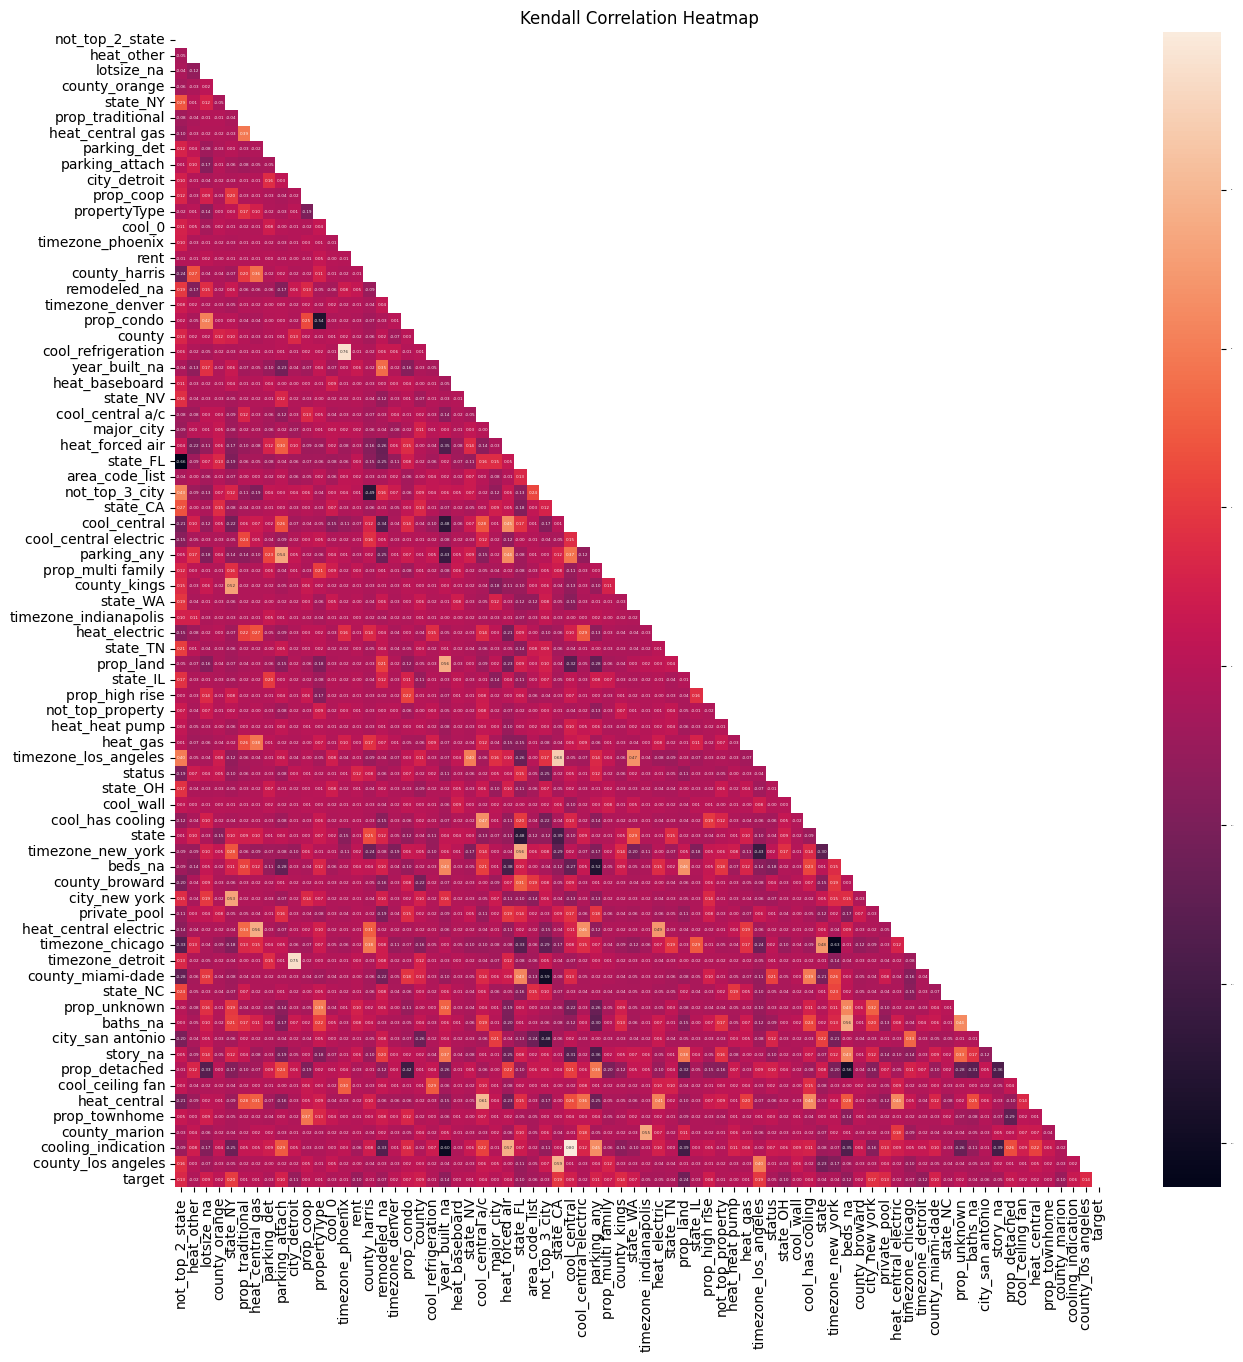

In [29]:
# print selected cat columns kendall correlation
matrix = np.triu(cat_df[selected_cat_col + ['target']].corr(method = 'kendall'))
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(cat_df[selected_cat_col + ['target']].corr(method = 'kendall'), xticklabels=True, yticklabels=True\
            , annot=True, mask=matrix, fmt = '.2f', annot_kws={"size": 3, "alpha" : 0.9})
cax = ax.figure.axes[-1]
cax.tick_params(labelsize=1)
plt.title('Kendall Correlation Heatmap')
plt.savefig('test_kendall_selected.png', dpi=600)

According to Anova test top categorical features that significantly affect the target:
- rent;
- prop_land;
- year_built_na;
- city_detroit;<br>
<br>
Most of the features that indicate low property value.<br>


According to Kendall correlation top categorical features that significantly affect the target:
- state_NY;
- state_CA;
- timezone_los angeles;
- city_new york;
- county_los angeles;<br>
<br>
All the features indicate the place

### Baseline

Run naive model with formatted original columns

In [30]:
base_data = data[['status', 'state', 'major_city', 'propertyType', 'beds', 'baths', 'story', 'target', 'sqft_med_na_log_1']].copy()
object_columns = ['status', 'state', 'major_city', 'propertyType']

# prepare X, y matrix
X = base_data.drop(['target'], axis = 1)
y = base_data['target']

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_seed)
display(X_train.shape, X_test.shape)

# encode categorical columns
encoder = OrdinalEncoder()
train_enc = encoder.fit_transform(X_train[object_columns], y_train)
val_enc = encoder.transform(X_test[object_columns])
train_enc = pd.DataFrame(train_enc, columns=encoder.get_feature_names_out())
val_enc = pd.DataFrame(val_enc, columns=encoder.get_feature_names_out())

# concat numerical and categorical encoded columns
X_train_encoded = pd.concat([X_train.drop(columns=object_columns), train_enc], axis=1)
X_test_encoded = pd.concat([X_test.drop(columns=object_columns), val_enc], axis=1)
display(X_train_encoded.shape, X_test_encoded.shape)

scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train_encoded)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# at first run only simple linear models
print('LinearRegression results, nonlog values')

# run the model & predict data
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
# look at metrics
print_evaluation_metrics(y_test, y_pred)
print('')

print('LinearRegression results, log values')
# run the model & predict data
model = LinearRegression()
model.fit(X_train_scaled, np.log(y_train))
y_pred = np.exp(model.predict(X_test_scaled))
# look at metrics
print_evaluation_metrics(y_test, y_pred)
print('')

# Also try more difficult models
# run the model & predict data
model = RandomForestRegressor(max_depth=10, random_state=random_seed)
model.fit(X_train_scaled, np.log(y_train))
y_pred = np.exp(model.predict(X_test_scaled))

# look at metrics
print('RandomForestRegression results, nonlog values')
print_evaluation_metrics(y_test, y_pred)
print('')

# run the model & predict data
model = RandomForestRegressor(max_depth=10, random_state=random_seed)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# look at metrics
print('RandomForestRegression results, log values')
print_evaluation_metrics(y_test, y_pred)

(203550, 8)

(87237, 8)

(203550, 8)

(87237, 8)

LinearRegression results, nonlog values
1725825229173.132 MSE
1313706.675 RMSE
0.033 normalized RMSE
0.165 R2 score
510832.941 MAE
2.44 MAPE
291875.837 MeAE

LinearRegression results, log values
1.999927086166955e+29 MSE
447205443411297.8 RMSE
11250522.165 normalized RMSE
-9.677853024570438e+16 R2 score
1558050990328.19 MAE
84716.854 MAPE
125048.711 MeAE

RandomForestRegression results, nonlog values
1176006655823.48 MSE
1084438.406 RMSE
0.027 normalized RMSE
0.431 R2 score
303482.494 MAE
0.674 MAPE
92175.635 MeAE

RandomForestRegression results, log values
951828911802.595 MSE
975617.195 RMSE
0.025 normalized RMSE
0.539 R2 score
318151.012 MAE
2.071 MAPE
128141.357 MeAE


RFR with default parameters except max_depth works much better and has better metrics.

### Try naive model with all selected columns

Prepare the data

In [31]:
# select the data
base_data = data[selected_cat_col + selected_num_col + ['target']].copy()

# Select object type columns
object_columns = base_data[selected_cat_col].select_dtypes(include='object').columns.tolist()
   
# prepare X, y matrix
X = base_data.drop(['target'], axis = 1)
y = base_data['target']

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_seed)

As data have not normal distribution use MinMaxScaler

In [32]:
# encode categorical columns
encoder = OrdinalEncoder()
train_enc = encoder.fit_transform(X_train[object_columns], y_train)
val_enc = encoder.transform(X_test[object_columns])
train_enc = pd.DataFrame(train_enc, columns=encoder.get_feature_names_out())
val_enc = pd.DataFrame(val_enc, columns=encoder.get_feature_names_out())

# concat numerical and categorical encoded columns
X_train_encoded = pd.concat([X_train.drop(columns=object_columns), train_enc], axis=1)
X_test_encoded = pd.concat([X_test.drop(columns=object_columns), val_enc], axis=1)
display(X_train_encoded.shape, X_test_encoded.shape)

# rescale the data
scaler = MinMaxScaler()
# Fit the scaler on the training data
scaler.fit(X_train_encoded)

# Transform the training and test data
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

(203550, 100)

(87237, 100)

In [33]:
# at first run only simple linear models
print('LinearRegression results, nonlog values')

# run the model & predict data
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# look at metrics
print_evaluation_metrics(y_test, y_pred)
print('')

# run the model & predict data
model = LinearRegression()
model.fit(X_train_scaled, np.log(y_train))
y_pred = np.exp(model.predict(X_test_scaled))

# look at metrics
print('LinearRegression results, log values')
print_evaluation_metrics(y_test, y_pred)
print('')

# also try more difficult models
# run the model & predict data
model = RandomForestRegressor(random_state = random_seed, max_depth=10)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# look at metrics
print('RandomForestRegression results, nonlog values')
print_evaluation_metrics(y_test, y_pred)
print('')

# run the model & predict data
model = RandomForestRegressor(random_state = random_seed, max_depth=10)
model.fit(X_train_scaled, np.log(y_train))
y_pred = np.exp(model.predict(X_test_scaled))

# look at metrics
print('RandomForestRegression results, log values')
print_evaluation_metrics(y_test, y_pred)

LinearRegression results, nonlog values
1223210757313.045 MSE
1105988.588 RMSE
0.028 normalized RMSE
0.408 R2 score
396161.695 MAE
2.722 MAPE
223192.0 MeAE

LinearRegression results, log values
3242455925827165.0 MSE
56942566.906 RMSE
1.433 normalized RMSE
-1568.058 R2 score
546173.236 MAE
0.64 MAPE
69199.444 MeAE

RandomForestRegression results, nonlog values
552441828311.671 MSE
743264.306 RMSE
0.019 normalized RMSE
0.733 R2 score
145257.915 MAE
2.14 MAPE
31387.998 MeAE

RandomForestRegression results, log values
656010351275.703 MSE
809944.659 RMSE
0.02 normalized RMSE
0.683 R2 score
121171.227 MAE
0.265 MAPE
16419.964 MeAE


All metrics are better in comparison with baseline linear model.<br>
In general rfr have better metrics than linear model. As linear models work faster, will try other linear models<br>
Use log target value as it leads to better results and have normal distribution.

#### Try different linear models with regularization

In [34]:
# create df to store metrics
metrics_df = pd.DataFrame(columns=['model', 'MSE', 'RMSE', 'R2 Score', 'MAE', 'MAPE', 'MeAE'])

# select model to try
models = [LinearRegression(), Lasso(), ElasticNet(), SGDRegressor(), Ridge()]

for lin_model in models:
    model = lin_model
    model.fit(X_train_scaled, np.log(y_train))
    y_pred = np.exp(model.predict(X_test_scaled))
    
    # collect all metrics
    mse = round(mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    meae = round(median_absolute_error(y_test, y_pred), 3)

    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'model': [str(lin_model).split('(')[0]],
        'MSE': [mse],
        'RMSE': [rmse],
        'R2 Score': [r2],
        'MAE': [mae],
        'MAPE': [mape],
        'MeAE': [meae],
    })], ignore_index=True)
    
# look at the result
metrics_df

,model,MSE,RMSE,R2 Score,MAE,MAPE,MeAE
0,LinearRegression,3242455925827165.000,56942566.906,-1568.058,546173.236,0.640,69199.444
1,Lasso,2173757314843.589,1474366.750,-0.052,456511.117,3.281,163461.507
2,ElasticNet,2173757314843.589,1474366.750,-0.052,456511.117,3.281,163461.507
3,SGDRegressor,2594507171169.481,1610747.395,-0.256,322964.563,0.652,71165.962
4,Ridge,2081338556102644.750,45621689.536,-1006.181,505675.095,0.638,69174.000


All linear models work faster but have worse metrics than rfr especially r2 score. Use rfr in all further stages.

### Try different outlier removal
#### IsolationForest

In [35]:
# # identify outliers in the training dataset
# iso = IsolationForest(contamination=0.1, random_state=random_seed)
# yhat = iso.fit_predict(X_train_encoded)
# # select all rows that are not outliers
# mask = yhat != -1
# X_train_encoded, y_train = X_train_encoded.iloc[mask, :], y_train[mask]
# # summarize the shape of the updated training dataset
# print(X_train_encoded.shape, y_train.shape)

# scaler = MinMaxScaler()

# # Fit the scaler on the training data
# scaler.fit(X_train_encoded)

# # Transform the training and test data
# X_train_scaled = scaler.transform(X_train_encoded)
# X_test_scaled = scaler.transform(X_test_encoded)

# # run the model & predict data
# model = RandomForestRegressor(random_state = random_seed, max_depth=10)
# model.fit(X_train_scaled, y_train)
# y_pred = model.predict(X_test_scaled)

# # look at metrics
# print('RFR nonlog results')
# print_evaluation_metrics(y_test, y_pred)

# # run the model & predict data
# model = RandomForestRegressor(random_state = random_seed, max_depth=10)
# model.fit(X_train_scaled, np.log(y_train))
# y_pred = np.exp(model.predict(X_test_scaled))

# # look at metrics
# print('RFR log results')
# print_evaluation_metrics(y_test, y_pred)

#### EllipticEnvelope

In [36]:
# # identify outliers in the training dataset
# ee = EllipticEnvelope(random_state=random_seed)
# yhat = ee.fit_predict(X_train_encoded)
# # select all rows that are not outliers
# mask = yhat != -1
# X_train_encoded, y_train = X_train_encoded.iloc[mask, :], y_train[mask]
# # summarize the shape of the updated training dataset
# print(X_train_encoded.shape, y_train.shape)

# scaler = MinMaxScaler()

# # Fit the scaler on the training data
# scaler.fit(X_train_encoded)

# # Transform the training and test data
# X_train_scaled = scaler.transform(X_train_encoded)
# X_test_scaled = scaler.transform(X_test_encoded)

# # run the model & predict data
# model = RandomForestRegressor(random_state = random_seed, max_depth=10)
# model.fit(X_train_scaled, y_train)
# y_pred = model.predict(X_test_scaled)

# # look at metrics
# print('RFR nonlog results')
# print_evaluation_metrics(y_test, y_pred)

# # run the model & predict data
# model = RandomForestRegressor(random_state = random_seed, max_depth=10)
# model.fit(X_train_scaled, np.log(y_train))
# y_pred = np.exp(model.predict(X_test_scaled))

# # look at metrics
# print('RFR log results')
# print_evaluation_metrics(y_test, y_pred)

#### LocalOutlierFactor

In [37]:
# # identify outliers in the training dataset
# lof = LocalOutlierFactor()
# yhat = lof.fit_predict(X_train_encoded)
# # select all rows that are not outliers
# mask = yhat != -1
# X_train_encoded, y_train = X_train_encoded.iloc[mask, :], y_train[mask]
# # summarize the shape of the updated training dataset
# print(X_train_encoded.shape, y_train.shape)

# scaler = MinMaxScaler()

# # Fit the scaler on the training data
# scaler.fit(X_train_encoded)

# # Transform the training and test data
# X_train_scaled = scaler.transform(X_train_encoded)
# X_test_scaled = scaler.transform(X_test_encoded)

# # run the model & predict data
# model = RandomForestRegressor(random_state = random_seed, max_depth=10)
# model.fit(X_train_scaled, y_train)
# y_pred = model.predict(X_test_scaled)

# # look at metrics
# print('RFR nonlog results')
# print_evaluation_metrics(y_test, y_pred)

# # run the model & predict data
# model = RandomForestRegressor(random_state = random_seed, max_depth=10)
# model.fit(X_train_scaled, np.log(y_train))
# y_pred = np.exp(model.predict(X_test_scaled))

# # look at metrics
# print('RFR log results')
# print_evaluation_metrics(y_test, y_pred)

Different outlier detection methods were used<br>

- IsolationForest;
- LocalOutlierFactor;
- EllipticEnvelope;
- DBSCAN (not presented here);<br>
<br>
None of it didn't improve the results significantly.

### Select the encoder

In [38]:
# # select the data
# base_data = data[selected_cat_col + selected_num_col + ['target']].copy()
# # Select object type columns
# feature_list = base_data[selected_cat_col].select_dtypes(include='object').columns.tolist()
   
# # prepare X, y matrix
# X = base_data.drop(['target'], axis = 1)
# y = base_data['target'] 

# # select encoders
# encoder_list = [OrdinalEncoder(), TargetEncoder(), MEstimateEncoder(), JamesSteinEncoder()\
#                 , LeaveOneOutEncoder() ,CatBoostEncoder(), CountEncoder(), HashingEncoder()]

# # split the data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = random_seed)

# # create df to store metrics
# metrics_df = pd.DataFrame(columns=['Encoder', 'MSE', 'RMSE', 'R2 Score', 'MAE', 'MAPE'])


# for encoder in encoder_list:
#     print("Test {} : ".format(str(encoder).split('(')[0]), end=" ")
    
#     # encode categorical features
#     train_enc = encoder.fit_transform(X_train[feature_list], y_train)
#     val_enc = encoder.transform(X_val[feature_list])
#     train_enc = pd.DataFrame(train_enc, columns=encoder.get_feature_names_out())
#     val_enc = pd.DataFrame(val_enc, columns=encoder.get_feature_names_out())
#     X_train_encoded = pd.concat([X_train.drop(columns=feature_list), train_enc], axis=1)
#     X_val_encoded = pd.concat([X_val.drop(columns=feature_list), val_enc], axis=1)
    
#     # rescale the data
#     scaler = MinMaxScaler()
#     # Fit the scaler on the training data
#     scaler.fit(X_train_encoded)

#     # Transform the training and test data
#     X_train_scaled = scaler.transform(X_train_encoded)
#     X_test_scaled = scaler.transform(X_val_encoded)

#     rfr = rfr_new
#     rfr.fit(X_train_scaled, np.log(y_train))
#     y_pred = np.exp(rfr.predict(X_test_scaled))
    
#     # collect all metrics
#     mse = round(mean_squared_error(y_val, y_pred), 3)
#     rmse = round(np.sqrt(mse), 3)
#     r2 = round(r2_score(y_val, y_pred), 3)
#     mae = round(mean_absolute_error(y_val, y_pred), 3)
#     mape = round(mean_absolute_percentage_error(y_val, y_pred), 3)
#     meae = round(median_absolute_error(y_val, y_pred), 3)
    
#     metrics_df = metrics_df.append({
#         'Encoder': str(encoder).split('(')[0],
#         'MSE': mse,
#         'RMSE': rmse,
#         'R2 Score': r2,
#         'MAE': mae,
#         'MAPE': mape,
#         'MeAE': meae
#     }, ignore_index=True)
    
#     del train_enc
#     del val_enc
#     del X_val_encoded
#     del X_train_encoded
#     gc.collect()

# # look at the metrics    
# metrics_df.sort_values(by='MAPE', ascending=False)

JamesSteinEncoder, TargetEncoder and MEstimateEncoder have the best scores.<br>
MEstimateEncoder perform better, have lower MAPE, will use it

### Reduce number of features using different feature selection methods

Prepare the data

In [39]:
# encode categorical columns
encoder = MEstimateEncoder()
train_enc = encoder.fit_transform(X_train[object_columns], y_train)
val_enc = encoder.transform(X_test[object_columns])
train_enc = pd.DataFrame(train_enc, columns=encoder.get_feature_names_out())
val_enc = pd.DataFrame(val_enc, columns=encoder.get_feature_names_out())

# concat numerical and categorical encoded columns
X_train_encoded = pd.concat([X_train.drop(columns=object_columns), train_enc], axis=1)
X_test_encoded = pd.concat([X_test.drop(columns=object_columns), val_enc], axis=1)
display(X_train_encoded.shape, X_test_encoded.shape)

# rescale the data
scaler = MinMaxScaler()
# Fit the scaler on the training data
scaler.fit(X_train_encoded)
# Transform the training and test data
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

(203550, 100)

(87237, 100)

#### RFE feature selection

In [40]:
# select the model
rfr_new = RandomForestRegressor(random_state=random_seed\
                                , min_samples_split=8\
                                , min_samples_leaf=15\
                                , max_depth=17)

# adjust rfe parameters
rfe_selector = RFE(estimator=rfr_new\
                    , n_features_to_select=85\
                    , step=10\
                    , verbose=5)

# run rfe
rfe_selector.fit(X_train_scaled, np.log(y_train))
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

# select features according to rfe
X_train_selected = X_train_encoded[rfe_feature]
X_test_selected = X_test_encoded[rfe_feature]

display(X_train_selected.shape)

# Fit the scaler on the training data
scaler = MinMaxScaler()
scaler.fit(X_train_selected)

# Transform the training and test data
X_train_scaled_rfe = scaler.transform(X_train_selected)
X_test_scaled_rfe = scaler.transform(X_test_selected)

# run the model & predict data
model = rfr_new
model.fit(X_train_scaled_rfe, np.log(y_train))
y_pred = np.exp(model.predict(X_test_scaled_rfe))

# look at metrics
print_evaluation_metrics(y_test, y_pred)

Fitting estimator with 100 features.
Fitting estimator with 90 features.
85 selected features


(203550, 85)

570711678436.85 MSE
755454.617 RMSE
0.019 normalized RMSE
0.724 R2 score
95354.99 MAE
0.185 MAPE
3091.21 MeAE


Rfe results have good metrics and less number of features

In [47]:
# rfe_feature

['not_top_2_state',
 'heat_other',
 'lotsize_na',
 'county_orange',
 'state_NY',
 'parking_det',
 'parking_attach',
 'city_detroit',
 'prop_coop',
 'timezone_phoenix',
 'rent',
 'county_harris',
 'remodeled_na',
 'timezone_denver',
 'county',
 'year_built_na',
 'heat_baseboard',
 'state_NV',
 'cool_central a/c',
 'major_city',
 'heat_forced air',
 'state_FL',
 'not_top_3_city',
 'state_CA',
 'cool_central electric',
 'parking_any',
 'prop_multi family',
 'county_kings',
 'state_WA',
 'timezone_indianapolis',
 'heat_electric',
 'state_TN',
 'state_IL',
 'prop_high rise',
 'not_top_property',
 'heat_gas',
 'timezone_los_angeles',
 'status',
 'cool_wall',
 'cool_has cooling',
 'timezone_new_york',
 'beds_na',
 'county_broward',
 'city_new york',
 'private_pool',
 'heat_central electric',
 'timezone_chicago',
 'timezone_detroit',
 'county_miami-dade',
 'city_san antonio',
 'story_na',
 'prop_detached',
 'cool_ceiling fan',
 'heat_central',
 'prop_townhome',
 'county_marion',
 'cooling_indi

In [ ]:
# save selected features
# rfe_features = ['not_top_2_state',
#                 'heat_other',
#                 'lotsize_na',
#                 'county_orange',
#                 'state_NY',
#                 'parking_det',
#                 'parking_attach',
#                 'city_detroit',
#                 'prop_coop',
#                 'timezone_phoenix',
#                 'rent',
#                 'county_harris',
#                 'remodeled_na',
#                 'timezone_denver',
#                 'county',
#                 'year_built_na',
#                 'heat_baseboard',
#                 'state_NV',
#                 'cool_central a/c',
#                 'major_city',
#                 'heat_forced air',
#                 'state_FL',
#                 'not_top_3_city',
#                 'state_CA',
#                 'cool_central electric',
#                 'parking_any',
#                 'prop_multi family',
#                 'county_kings',
#                 'state_WA',
#                 'timezone_indianapolis',
#                 'heat_electric',
#                 'state_TN',
#                 'state_IL',
#                 'prop_high rise',
#                 'not_top_property',
#                 'heat_gas',
#                 'timezone_los_angeles',
#                 'status',
#                 'cool_wall',
#                 'cool_has cooling',
#                 'timezone_new_york',
#                 'beds_na',
#                 'county_broward',
#                 'city_new york',
#                 'private_pool',
#                 'heat_central electric',
#                 'timezone_chicago',
#                 'timezone_detroit',
#                 'county_miami-dade',
#                 'city_san antonio',
#                 'story_na',
#                 'prop_detached',
#                 'cool_ceiling fan',
#                 'heat_central',
#                 'prop_townhome',
#                 'county_marion',
#                 'cooling_indication',
#                 'county_los angeles',
#                 'school_rating_min',
#                 'school_rating_max',
#                 'school_distance_min_log',
#                 'school_distance_median_log',
#                 'baths',
#                 'beds',
#                 'population_density',
#                 'story',
#                 'lotsize_med_prop_1',
#                 'type_word_1',
#                 'type_hc_1',
#                 'type_hc_2',
#                 'sqft_med_na_log_1',
#                 'occupied_housing_units',
#                 'year_built',
#                 'remodeled',
#                 'price_sqft_na_out_med',
#                 'lat',
#                 'lng',
#                 'radius_in_miles',
#                 'water_area_in_sqmi',
#                 'median_home_value',
#                 'median_household_income',
#                 'distance_to_center_log',
#                 'parking_number',
#                 'land_area_in_sqmi_log',
#                 'non_na_count']

#### SelectFromModel

In [ ]:
# # adjust select from model parameters
# feature_selection = SelectFromModel(rfr_new)
# feature_selection.fit(X_train_scaled, np.log(y_train))

# feature_support = feature_selection.get_support()
# selected_features = X.loc[:,feature_support].columns.tolist()
# print(str(len(selected_features)), 'selected features')

# X_train_selected = X_train_encoded[selected_features]
# X_test_selected = X_test_encoded[selected_features]

# scaler = MinMaxScaler()

# # Fit the scaler on the training data
# scaler.fit(X_train_selected)

# # Transform the training and test data
# X_train_scaled_emb = scaler.transform(X_train_selected)
# X_test_scaled_emb = scaler.transform(X_test_selected)

# # run the model & predict data
# model = rfr_new
# model.fit(X_train_scaled_emb, np.log(y_train))
# y_pred = np.exp(model.predict(X_test_scaled_emb))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

SelectFromModel method selects to low number of features (only 11 with default settings) and made all metrics worse.

#### Feature importance

In [ ]:
# # Create an empty DataFrame to store feature importance
# feature_importance_df = pd.DataFrame({'Feature': X.columns})

# # List of models with default settings except max_depth
# models = [
#     RandomForestRegressor(random_state=random_seed, n_jobs = 6, max_depth = 10),
#     LGBMRegressor(random_state=random_seed, n_jobs = 6, max_depth = 10),
#     XGBRegressor(random_state=random_seed, n_jobs = 6, max_depth = 10),
#     CatBoostRegressor(random_state=random_seed, max_depth = 10),
#     GradientBoostingRegressor(random_state=random_seed, max_depth = 10)
# ]

# # Loop through each model
# for model in models:
    
#     print(f'Starting to fit {model} model')
    
#     # Fit the model
#     model.fit(X_train_scaled, np.log(y_train))
    
#     # Get feature importance
#     if hasattr(model, 'feature_importances_'):  # Check if the model has feature_importances_
#         feature_importance = model.feature_importances_
#     elif hasattr(model, 'coef_'):  # Check if the model has coef_
#         feature_importance = model.coef_
#     else:
#         raise AttributeError(f"Model '{type(model).__name__}' does not have attribute for feature importance.")
    
#     # Create a DataFrame for the current model's feature importance
#     model_importance_df = pd.DataFrame({
#     'Feature': X.columns,
#     type(model).__name__: feature_importance
# })
    
#     # Append the current model's feature importance to the main DataFrame
#     feature_importance_df = pd.merge(feature_importance_df, model_importance_df, on='Feature', how='outer')
    
# # look at the result
# feature_importance_df.head()

In [ ]:
# # select only features which has non zero importance at least at one regressor
# filtered_df = feature_importance_df[(np.round(feature_importance_df.iloc[:, 1:], 3) != 0).any(axis=1)]
# rest_data = feature_importance_df[~feature_importance_df.Feature.isin(filtered_df.Feature)]
# display(rest_data.shape)
# display(filtered_df.shape)

In [ ]:
# # run the model to check the results
# selected_features = filtered_df['Feature'].tolist()
# X_train_selected = X_train_encoded[selected_features]
# X_test_selected = X_test_encoded[selected_features]

# scaler = MinMaxScaler()

# # Fit the scaler on the training data
# scaler.fit(X_train_selected)

# # Transform the training and test data
# X_train_scaled_fs = scaler.transform(X_train_selected)
# X_test_scaled_fs = scaler.transform(X_test_selected)

# # run the model & predict data
# model = rfr_new

# model.fit(X_train_scaled_fs, np.log(y_train))
# y_pred = np.exp(model.predict(X_test_scaled_fs))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

Feature importance selected 86 features, but final metrics become worse.<br>
<br>
RFE selected 85 features and have good metrics, will use it

### Select the best model<br>
Several tunned models will be tried

#### RFR & RandomizedSearchCV

In [42]:
# Create the parameter grid 
param_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 20, num = 5)],
    'min_samples_leaf': [int(x) for x in np.linspace(5, 20, num = 7)],
    'min_samples_split': [int(x) for x in np.linspace(10, 20, num = 7)],
    # 'n_estimators':  np.arange(50, 500, 50)
}

# Create a based model
rf = RandomForestRegressor(random_state=random_seed)

# create the search model
rf_grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 5\
                                    , n_jobs = -1, verbose = 10, random_state=random_seed)

rf_grid_search.fit(X_train_scaled_rfe, np.log(y_train))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=10, min_samples_leaf=12, min_samples_split=15....[CV 3/5; 2/10] START max_depth=10, min_samples_leaf=5, min_samples_split=20.....

[CV 3/5; 1/10] START max_depth=10, min_samples_leaf=12, min_samples_split=15....
[CV 1/5; 2/10] START max_depth=10, min_samples_leaf=5, min_samples_split=20.....
[CV 5/5; 1/10] START max_depth=10, min_samples_leaf=12, min_samples_split=15....
[CV 2/5; 1/10] START max_depth=10, min_samples_leaf=12, min_samples_split=15....
[CV 2/5; 2/10] START max_depth=10, min_samples_leaf=5, min_samples_split=20.....
[CV 4/5; 1/10] START max_depth=10, min_samples_leaf=12, min_samples_split=15....
[CV 5/5; 1/10] END max_depth=10, min_samples_leaf=12, min_samples_split=15;, score=0.872 total time=20.6min
[CV 4/5; 2/10] START max_depth=10, min_samples_leaf=5, min_samples_split=20.....
[CV 3/5; 2/10] END max_depth=10, min_samples_leaf=5, min_samples_split=20;, score=0.881 total time=20.

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 12, 15, 17, 20],
                                        'min_samples_leaf': [5, 7, 10, 12, 15,
                                                             17, 20],
                                        'min_samples_split': [10, 11, 13, 15,
                                                              16, 18, 20]},
                   random_state=42, verbose=10)

In [43]:
# run the model & predict data
model = rf_grid_search

y_pred = np.exp(model.predict(X_test_scaled_rfe))

# look at metrics
print('Test results')
print_evaluation_metrics(y_test, y_pred)
print('')

y_pred = np.exp(model.predict(X_train_scaled_rfe))

# look at metrics
print('Train results')
print_evaluation_metrics(y_train, y_pred)

Test results
514673083019.434 MSE
717407.195 RMSE
0.018 normalized RMSE
0.751 R2 score
87170.752 MAE
0.167 MAPE
2177.296 MeAE

Train results
436965007698.553 MSE
661033.288 RMSE
0.017 normalized RMSE
0.793 R2 score
73209.399 MAE
0.106 MAPE
1723.779 MeAE


In [44]:
rf_grid_search.best_params_

{'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 20}

In [45]:
# create the model with selected parameters
rfr_hyper = RandomForestRegressor(random_state=random_seed\
                                , min_samples_split=15\
                                , min_samples_leaf=5\
                                , max_depth=20)

rfr_hyper.fit(X_train_scaled_rfe, np.log(y_train))

RandomForestRegressor(max_depth=20, min_samples_leaf=5, min_samples_split=15,
                      random_state=42)

#### Catboost & RandomizedSearchCV

In [ ]:
# # tune hyperparameters for the catboost
# grid = {
#     'depth': [int(x) for x in np.linspace(1, 20, num = 8)],
#     'learning_rate': np.linspace(0.01, 0.3, num=8).tolist(),
#     'n_estimators': np.arange(50, 500, 50),
#     'min_data_in_leaf': [int(x) for x in np.linspace(1, 20, num = 9)],
#     'reg_lambda': [1, 3, 5, 7],
#     'loss_function': ['MAPE', 'RMSE']
#     }

# cat_model = CatBoostRegressor(random_state=random_seed)

# # create the search model
# cat_grid_search = RandomizedSearchCV(estimator = cat_model, param_distributions = grid, cv = 5/
#                                       , n_jobs = -1, verbose = 2, random_state=random_seed)


# cat_grid_search.fit(X_train_scaled_rfe, np.log(y_train))

# y_pred = np.exp(cat_grid_search.predict(X_test_scaled_rfe))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

In [ ]:
# cat_grid_search.best_params_

#### GradientBoostingRegressor & RandomizedSearchCV

In [ ]:
# #  tune hyperparameters for the gradient boosting
# param_grid = {
#     'learning_rate': np.linspace(0.01, 0.3, num=8).tolist(),
#     'max_depth': [int(x) for x in np.linspace(1, 10, num = 8)],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [int(x) for x in np.linspace(1, 20, num = 9)],
#     'min_samples_split': [int(x) for x in np.linspace(1, 20, num = 9)],
#     'n_estimators':  [int(x) for x in np.linspace(start = 100, stop = 1100, num = 6)],
# }

# gbr = GradientBoostingRegressor(random_state=random_seed)

# gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = param_grid, cv = 5\
#                                 , verbose=2, random_state=random_seed, n_jobs = -1)

# gbr_random.fit(X_train_scaled_rfe, np.log(y_train))

# y_pred = np.exp(gbr_random.predict(X_test_scaled_rfe))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

In [ ]:
# gbr_random.best_params_

#### XGBoost & RandomizedSearchCV

In [ ]:
# # tunning XGBoost hyperparameters using randomsearch
# param_tuning = {
#         'learning_rate': np.linspace(0.01, 0.3, num=8).tolist(),
#         'lambda': [int(x) for x in np.linspace(0.01, 1, num = 5)],
#         'max_depth': [int(x) for x in np.linspace(1, 10, num = 8)],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7, 1],
#         'colsample_bytree': [0.5, 0.7],
#         'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 1100, num = 6)]
#         }

# xgb_model = XGBRegressor(random_state=random_seed)

# xgb_random = RandomizedSearchCV(xgb_model, param_tuning, n_jobs=-1, cv = 5, random_state=random_seed\
#                                 , refit=True, return_train_score=True, verbose=10)

# xgb_random.fit(X_train_scaled_rfe, np.log(y_train))

# y_pred = np.exp(xgb_random.predict(X_test_scaled_rfe))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

In [ ]:
# xgb_random.best_params_

#### LightGBM & RandomizedSearchCV

In [ ]:
# # tune lgbm hyperparameters
# lgbm_tune_kwargs = {
#        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 8)],
#        'max_depth': np.arange(3, 16, 3),
#        'num_leaves': [int(x) for x in np.linspace(start = 16, stop = 50, num = 8)],
#        'min_data_in_leaf': np.arange(100, 1500, 300),
#        'bagging_fraction': [0.5, 0.7, 1],    # xgb subsample
#        'feature_fraction': [0.05, 0.5, 0.7],   # xgb colsample_bytree
#        'learning_rate': np.linspace(0.01, 0.3, num=8).tolist(),
#         'boosting': ['gbdt', 'gbrt', 'rf', 'random_forest', 'dart', 'goss'],
#         'lambda_l1': [int(x) for x in np.linspace(0.01, 1, num = 5)],
#         'lambda_l2': [int(x) for x in np.linspace(0.01, 1, num = 5)]
#         }

# lgbm_model = LGBMRegressor(random_state=random_seed)

# light_grid = RandomizedSearchCV(lgbm_model, lgbm_tune_kwargs, n_jobs=-1, cv =5, random_state=random_seed\
#                                 , refit = True, return_train_score = True, verbose = 10)

# light_grid.fit(X_train_scaled_rfe, np.log(y_train))

# y_pred = np.exp(light_grid.predict(X_test_scaled_rfe))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

In [ ]:
# light_grid.best_params_

According to the metrics:<br>
- RandomForestRegressor has the best MeAE and MAE;<br>
- XGBRegressor has the highest R2 score;<br>
- GBRegressor has the lowest MAPE score;<br>
- all tunned models have better scores in comparison with rfr from the box.

### Bagging of boosted models

#### XGBRegressor bagging

In [ ]:
# bagging_xgb = BaggingRegressor(XGBRegressor(random_state=random_seed\
#                                             , subsample=1\
#                                             , n_estimators=900\
#                                             , min_child_weight=3\
#                                             , max_depth=8\
#                                             , learning_rate=0.21714285714285714\
#                                             # , lambda=0\
#                                             , colsample_bytree=0.5)\
#                                , random_state=random_seed\
#                                 , n_jobs=-1)

# bagging_xgb.fit(X_train_scaled_rfe, np.log(y_train))

# y_pred = np.exp(bagging_xgb.predict(X_test_scaled_rfe))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

#### GBRegressor bagging

In [ ]:
# bagging_gbr = BaggingRegressor(GradientBoostingRegressor(random_state=random_seed\
#                                                         , n_estimators=300\
#                                                         , min_samples_split=5\
#                                                         , min_samples_leaf=17\
#                                                         , max_features='auto'\
#                                                         , max_depth=8\
#                                                         , learning_rate=0.13428571428571429)\
#                                 , random_state=random_seed\
#                                 , n_jobs=-1)

# bagging_gbr.fit(X_train_scaled_rfe, np.log(y_train))

# y_pred = np.exp(bagging_gbr.predict(X_test_scaled_rfe))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

Bagging improved xgb, gbr results, but made r2 score worse.

### Stacking<br>
2 best models will be used for stacking: rfr with hyperparameters and bagging of xgb,<br>
linearregression will be used as final estimator

In [ ]:
# # define the base models
# level0 = list()
# level0.append(('rfr', rfr_hyper))
# level0.append(('xgb_bag', bagging_xgb))

# # define meta learner model
# level1 = LinearRegression()

# # define the stacking ensemble
# stack_rfr_xgb = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

# stack_rfr_xgb.fit(X_train_scaled_rfe, np.log(y_train))

# y_pred = np.exp(stack_rfr_xgb.predict(X_test_scaled_rfe))

# # look at metrics
# print_evaluation_metrics(y_test, y_pred)

Stacking improved xgb results, has less MeAE and MAE but not as good as rfr model, it also has better r2 score.<br>
<br>
The best model is rfr model with hyperparameters.

#### Find the most significant features

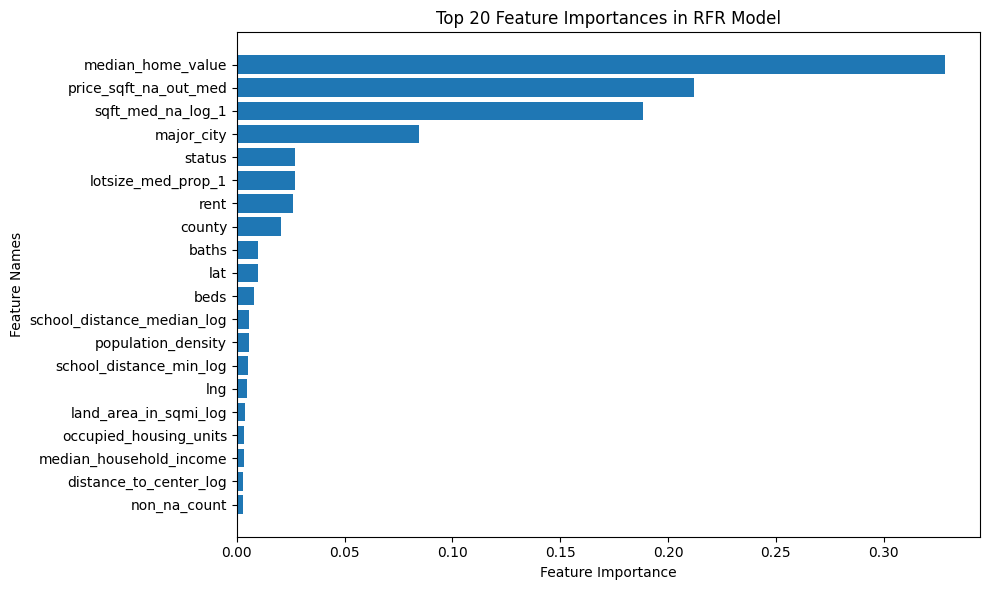

In [46]:
# Extract feature importances
feature_importances = rfr_hyper.feature_importances_

# Get the indices of the top 20 features based on their importance
top_20_indices = np.argsort(feature_importances)[::-1][:20]

# Get the corresponding feature names
features = rfe_feature

top_20_feature_names = [features[i] for i in top_20_indices]

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(top_20_feature_names)), feature_importances[top_20_indices], align='center')
plt.yticks(np.arange(len(top_20_feature_names)), top_20_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top 20 Feature Importances in RFR Model')
plt.gca().invert_yaxis()  # Invert y-axis to display features from top to bottom
plt.tight_layout()
plt.show()

As it was observed on feature selection stage, the most important features mostly related to the:
- income of the population in the area,
- with the area of the property,
- number of baths and property size,
- rent (if it's property for rent)
- distance to school and to center,
- property location
- property status.

What could be done to improve the results:
- the data could be divided into property for rent and for sale and separate models could be trained;
- more precise parameters tuning;
- more precise outlier removal, trying different parameters;